### 7.1 VGGNet(2014)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tqdm as tqdm

In [2]:
import os
root_dir = "/content/drive/MyDrive/2022 DataCreatorCamp_나 is NICE/new_dataset/"
image_label = os.listdir(root_dir)
image_label = image_label[:5]
image_label


['L2_10', 'L2_12', 'L2_15', 'L2_20', 'L2_21']

In [3]:
# opencv를 통해 이미지 로드하고 이미지의 사이즈가 모두 동일하게 변경
train_x = []
train_y = []
test_x = []
test_y = []
dataset = []

def create_dataset(directory, dir_name):
  for i in tqdm.tqdm(os.listdir(directory)):
    full_path = os.path.join(directory, i)
    try:
      img = cv2.imread(full_path) #이미지 읽기
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #RGB형태로 변환
      img = cv2.resize(img, (150,150)) #이미지 사이즈 변경
    except:
      continue

    if dir_name == "alien_test":
      test_x.append(img)
      test_y.append(i)
    else:
      train_x.append(img)
      train_y.append(dir_name)
  return train_x, train_y, test_x, test_y

In [4]:
for img_label in image_label:
  trian_x, train_y, test_x, test_y = create_dataset(f"{root_dir}{img_label}", img_label)

100%|██████████| 410/410 [00:07<00:00, 55.21it/s] 


In [5]:
#배열 형태로 x, y 값 변경
x = np.array(train_x)
y = np.array(train_y)
x.shape, y.shape

((4740, 150, 150, 3), (4740,))

In [6]:
#학습세트와 검증세트를 분리
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
img_size =150 #이미지 150픽셀로 만들어줌

x_train = np.array(x_train)/255.0 #학습에 사용하기 적합한 형태로 만들어줌
x_valid = np.array(x_valid)/255.0

x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_valid = x_valid.reshape(-1, img_size, img_size, 3)
y_valid = np.array(y_valid)

In [8]:
#예측에 사용할 데이터 세트의 사이즈 변경
x_test = np.array(test_x).reshape(-1, img_size, img_size, 3)
x_test.shape

(0, 150, 150, 3)

In [9]:
#LabelBinaizer을 통해 정답값을 one-hot 형태로 변경
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_valid_lb = lb.fit_transform(y_valid)
y_train_lb.shape, y_valid_lb.shape

((3792, 5), (948, 5))

#### VGG19

In [10]:
# 19개 층 사용하는 vgg19 모델 불러옴
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

80134624/80134624 [==============================] - 2s 0us/step


In [11]:
for layer in vgg.layers:
  layer.trainable = False

In [12]:
# Sequential 층에서 vgg 모델 추가
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 5)                 40965     
                                                                 
Total params: 20,065,349
Trainable params: 40,965
Non-trainable params: 20,024,384
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics='accuracy')

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

In [15]:
unique, counts = np.unique(y_train_lb, return_counts=True)
print(unique, counts)

[0 1] [15168  3792]


In [16]:
history = model.fit(x_train, y_train_lb, epochs=30, validation_data=(x_valid, y_valid_lb), 
                    batch_size=32, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/30
119/119 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.8434
Epoch 1: val_accuracy improved from -inf to 0.95359, saving model to vgg19.h5
119/119 [==============================] - 26s 141ms/step - loss: 0.4881 - accuracy: 0.8434 - val_loss: 0.2095 - val_accuracy: 0.9536
Epoch 2/30
119/119 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9607
Epoch 2: val_accuracy improved from 0.95359 to 0.97046, saving model to vgg19.h5
119/119 [==============================] - 14s 120ms/step - loss: 0.1622 - accuracy: 0.9607 - val_loss: 0.1375 - val_accuracy: 0.9705
Epoch 3/30
119/119 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9829
Epoch 3: val_accuracy improved from 0.97046 to 0.97574, saving model to vgg19.h5
119/119 [==============================] - 15s 124ms/step - loss: 0.0983 - accuracy: 0.9829 - val_loss: 0.1061 - val_accuracy: 0.9757
Epoch 4/30
119/119 [==============================] - ETA: 0s - loss: 

In [17]:
# 학습 결과를 데이터프레임 형태로 변환
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,0.488094,0.843354,0.209485,0.953587
1,0.162228,0.960707,0.137517,0.970464
2,0.098303,0.982859,0.106063,0.975738
3,0.066993,0.991034,0.088596,0.981013
4,0.046634,0.995517,0.088635,0.974684


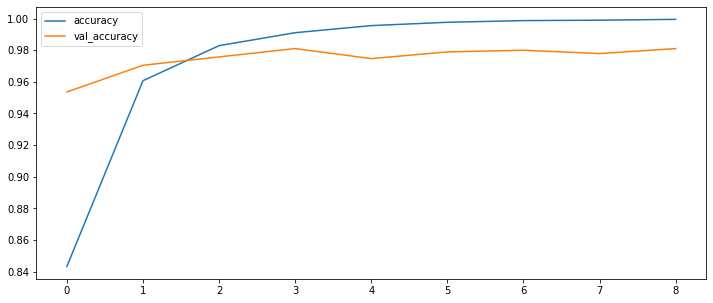

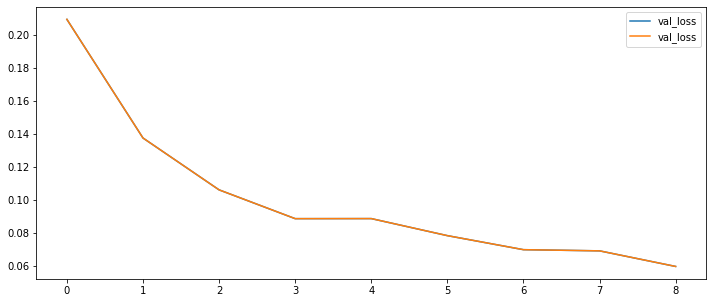

In [18]:
# 학습 결과 시각화
df_hist[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
df_hist[['val_loss', 'val_loss']].plot(figsize=(12,5))

In [ ]:
# 예측 시작
predict = model.predict(x_test)
y_predict = np.argmax(predict, axis=1)
y_predict

In [ ]:
# 정답지 불러옴
df_test = pd.read_csv(f"{root_dir}/test.csv") #여기에 경로 넣기
df_test = df_test.set_index("Image_id").loc[test_y].reset_index()
df_test.head()

In [ ]:
y_test = df_test['labels']

In [ ]:
# 정확도 직접 구하기
(y_test == y_predict).mean()

In [ ]:
# 변경된 값 비교해 보기 위해 정답값을 딕셔너리 형태로 만듦

label_name = dict(zip(np.argmax(y_train_lb, axis=1), y_train))
label_name

In [ ]:
# 정답지 시각화
plt.figure(figsize=(12,15))
for index, row in df_test.iterrows():
  filename = row['Image_id']
  category = row['labels']
  img = x_test[index]
  plt.subplot(6,5,index+1)
  plt.imshow(img)
  if category != y_predict[index]:
    c="red"
  else:
    c="black"
  plt.xlabel(f"{filename}(label_name[y_predict[index]]}", color = c)
plt.tight_layout()
plt.show()